In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_spd_matrix 
from sklearn.cluster import KMeans


# Sample

In [145]:
def gauss2D(x, m, C):
    Ci = np.linalg.inv(C)
    dC = np.linalg.det(Ci)
    
    num = np.exp(-0.5 * np.dot((x - m).T, np.dot(Ci, (x - m))))
    den = 2 * np.pi * dC
    
    return num / den

def twoDGaussianPlot(nx, ny, m, C):
    x = np.linspace(-4, 8, nx)
    y = np.linspace(-4, 8, ny)

    X, Y = np.meshgrid(x, y, indexing='ij')
    Z = np.zeros([nx, ny])

    for i in range(nx):
        for j in range(ny):
            xvec = np.array([X[i, j], Y[i, j]])
            Z[i, j] = gauss2D(xvec, m, C)

    return X, Y, Z

def genGaussianSamples(N, m, C):
    A = np.linalg.cholesky(C)

    X = np.random.randn(N, 2) 

    Y = X @ A.T + m
 
    return Y

In [150]:
# Define three means
Means = np.array([[0, 3], [3, 0], [4, 4]])

# Define three covariance matrices ensuring # they are positive definite
CovMatrices = np.zeros((3, 2, 2))
for j in range(3):
    CovMatrices[j,:,:] = make_spd_matrix(2)

In [151]:
# Priors
w = np.random.rand(3)
w = w / np.sum(w)

# How many data in each component (1000 in total) #
nData = np.floor(w * 1000).astype(int)

In [152]:
# Draw samples from each component
X0 = genGaussianSamples(nData[0], Means[0,:], CovMatrices[0,:,:])
X1 = genGaussianSamples(nData[1], Means[1,:], CovMatrices[1,:,:])
X2 = genGaussianSamples(nData[2], Means[2,:], CovMatrices[2,:,:])

# Append into an array for the data we need
X = np.append(np.append(X0, X1, axis=0), X2, axis=0)

# Draw contours

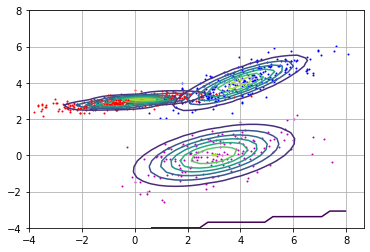

In [153]:
nx, ny = 40, 40
Xp1, Yp1, Zp1 = twoDGaussianPlot(nx, ny, Means[0], CovMatrices[0,:,:])
Xp2, Yp2, Zp2 = twoDGaussianPlot(nx, ny, Means[1], CovMatrices[1,:,:])
Xp3, Yp3, Zp3 = twoDGaussianPlot(nx, ny, Means[2], CovMatrices[2,:,:])


fig, ax = plt.subplots()
ax.grid(True)

ax.scatter(X0[:,0], X0[:,1], c='r', s=1)
ax.scatter(X1[:,0], X1[:,1], c='m', s=1)
ax.scatter(X2[:,0], X2[:,1], c='b', s=1)

ax.contour(Xp1, Yp1, Zp1)
ax.contour(Xp2, Yp2, Zp2)
ax.contour(Xp3, Yp3, Zp3)

# Kmeans

In [154]:
def distance(x, c):
    return np.linalg.norm(x - c)


def Estep(p, centers):
    minimum = np.inf
    index = 0

    for i in range(len(centers)):
        temp = distance(p, centers[i])
    
        if temp < minimum:
            minimum = temp
            index = i

    return index, minimum


def Mstep(clusters):
    d = clusters[0].shape[1]
    new_centers = np.empty((0, d))

    for cl in clusters:
        c = []
        for i in range(d):
            c.append(np.mean(cl[:, i]))

        new_centers = np.vstack([new_centers, np.array(c)])

    return new_centers


def Kmeans(X, centers, clusterNum = 3, dimension = 2, threshold=10):
    newE = 0 

    # record the postition of each cluster center separately in each step
    clusterCenterEachStep = [np.empty((0, dimension)), np.empty((0, dimension)), np.empty((0, dimension))]

    while True:
        for i in range(clusterNum):
            clusterCenterEachStep[i] = np.vstack([clusterCenterEachStep[i], centers[i]])

        oldE = newE
        newE = 0
        
        cluster = [ np.empty((0, dimension)) for i in range(clusterNum) ]
        cluster_label = []

        for p in X:
            i, min_distance = Estep(p, centers)

            cluster[i] = np.vstack([cluster[i], np.expand_dims(p, axis=0)])
            
            cluster_label.append(i)
            
            newE += min_distance

        centers = Mstep(cluster)

        if np.abs(newE - oldE) <= threshold:
            break

    return centers, cluster,clusterCenterEachStep, cluster_label

### initial cluster centers

In [155]:
clusterNum = 3

center_x = np.random.choice(np.arange(np.min(X[:, 0]), np.max(X[:, 0]), 0.05), clusterNum)
center_y = np.random.choice(np.arange(np.min(X[:, 1]), np.max(X[:, 1]), 0.05), clusterNum)

initial_centers = np.append(center_x[:,np.newaxis], center_y[:, np.newaxis], axis=1)

In [156]:
centers, cluster, clusterCenterEachStep, _ = Kmeans(X, initial_centers)


In [157]:
# total steps
len(clusterCenterEachStep[0])

7

In [158]:
cluster[0].shape, cluster[1].shape, cluster[2].shape


((551, 2), (290, 2), (158, 2))

In [159]:
# final center
centers

array([[-0.15500827,  2.97247508],
       [ 4.07759705,  3.97656471],
       [ 2.89795576, -0.09207378]])

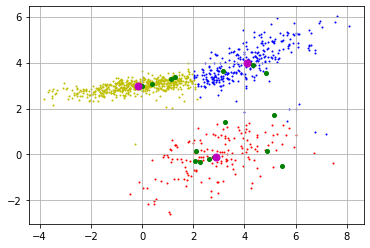

In [160]:
fig, ax = plt.subplots()
ax.grid(True)

# ax.scatter(X0[:,0], X0[:,1], c='k', s=1)
# ax.scatter(X1[:,0], X1[:,1], c='k', s=1)
# ax.scatter(X2[:,0], X2[:,1], c='k', s=1)
ax.scatter(cluster[0][:,0], cluster[0][:,1], c='y', s=1)
ax.scatter(cluster[1][:,0], cluster[1][:,1], c='b', s=1)
ax.scatter(cluster[2][:,0], cluster[2][:,1], c='r', s=1)
    
colors = ['go', 'go', 'go']
for (i, clusters) in enumerate(clusterCenterEachStep):
    ax.plot(clusters[:,0][0:-1], clusters[:, 1][0:-1], colors[i], markersize=4)
    ax.plot(clusters[:,0][-1:], clusters[:, 1][-1:], 'mo', markersize=7)

In [161]:
def getScore():
    score=0
    for i in range(3):
        for p in cluster[i]:
            score+=distance(p, centers[i])**2
    return score

getScore()


2052.9887497950963

# Sklearn

In [162]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

sk_centers = kmeans.cluster_centers_
sk_centers

array([[ 4.00220261,  3.97452959],
       [-0.18692452,  2.9699786 ],
       [ 2.94886648, -0.07918289]])

In [163]:
np.sum(kmeans.labels_==0), np.sum(kmeans.labels_==1), np.sum(kmeans.labels_==2)

(295, 544, 160)

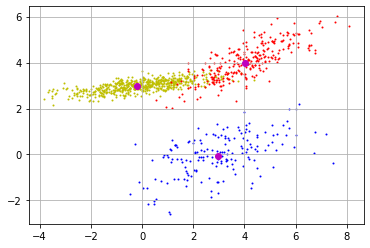

In [164]:
fig, ax = plt.subplots()
ax.grid(True)

ax.scatter(X0[:,0], X0[:,1], c='y', s=1)
ax.scatter(X1[:,0], X1[:,1], c='b', s=1)
ax.scatter(X2[:,0], X2[:,1], c='r', s=1)

ax.plot(sk_centers[:,0], sk_centers[:, 1], 'mo')

In [165]:
kmeans.score(X)


-2052.2956555816118

# Failure case

In [186]:
cluster_num = 3

center_x = np.random.choice(np.arange(np.min(X[:, 0]), np.max(X[:, 0]), 0.05), cluster_num)
center_y = np.random.choice(np.arange(np.min(X[:, 1]), np.max(X[:, 1]), 0.05), cluster_num)

center_x = np.array([-2, 2, 6])
center_y = np.array([0, 2, 5])

initial_centers_1 = np.append(center_x[:,np.newaxis], center_y[:, np.newaxis], axis=1)

In [187]:
centers, cluster, clusterCenterEachStep, _ = Kmeans(X, initial_centers_1, cluster_num)

In [188]:
cluster[0].shape, cluster[1].shape, cluster[2].shape

((411, 2), (346, 2), (242, 2))

In [189]:
# final center
centers

array([[-0.67528165,  2.92203996],
       [ 2.1401834 ,  1.74395785],
       [ 4.51242933,  4.01703321]])

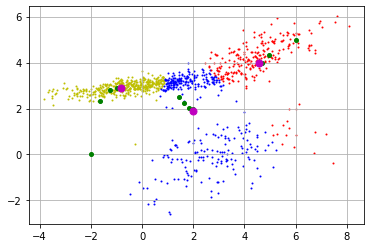

In [190]:
fig, ax = plt.subplots()
ax.grid(True)

ax.scatter(cluster[0][:,0], cluster[0][:,1], c='y', s=1)
ax.scatter(cluster[1][:,0], cluster[1][:,1], c='b', s=1)

ax.scatter(cluster[2][:,0], cluster[2][:,1], c='r', s=1)

# colors = ['go', 'mo', 'co']
colors = ['go', 'go', 'go']
for (i, clusters) in enumerate(clusterCenterEachStep):
    ax.plot(clusters[:,0][0:-1], clusters[:, 1][0:-1], colors[i], markersize=4)
    ax.plot(clusters[:,0][-1:], clusters[:, 1][-1:], 'mo', markersize=7)

In [192]:
getScore()


2504.000069355881

In [193]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
kmeans.score(X)


-2052.2956555816118

# UCI Study

In [61]:
dataset = pd.read_csv('./data/Seed_Data.csv')

In [62]:
dataset.shape, dataset.head()

((210, 8),
        A      P       C     LK     WK  A_Coef    LKG  target
 0  15.26  14.84  0.8710  5.763  3.312   2.221  5.220       0
 1  14.88  14.57  0.8811  5.554  3.333   1.018  4.956       0
 2  14.29  14.09  0.9050  5.291  3.337   2.699  4.825       0
 3  13.84  13.94  0.8955  5.324  3.379   2.259  4.805       0
 4  16.14  14.99  0.9034  5.658  3.562   1.355  5.175       0)

In [63]:
features = dataset.iloc[:, 0:7]

In [64]:
target = dataset.iloc[:, -1]

In [65]:
cluster_num = 3

init_center = []
for i in range(7):
    x = np.random.choice(np.arange(np.min(features.iloc[:, i]), np.max(features.iloc[:, i]), 0.05), cluster_num)
    init_center.append( x[:, np.newaxis] )

initial_centers_2 = np.concatenate(init_center, axis=1)

In [71]:
centers, cluster, _, cluster_label = Kmeans(features.to_numpy(), initial_centers_2, cluster_num, dimension = 7)


In [72]:
centers

array([[14.98238806, 14.6141791 ,  0.88081493,  5.61983582,  3.31802985,
         2.76849552,  5.25810448],
       [12.03011765, 13.29870588,  0.85380706,  5.22872941,  2.88884706,
         4.52030588,  5.06558824],
       [18.82068966, 16.34327586,  0.88485345,  6.2245    ,  3.73184483,
         3.57460345,  6.08322414]])

### Evaluation

In [68]:
from scipy.stats import mode

def make_labels(y, clusters):
    labels = np.zeros_like(clusters)

    for i in range(3):
        mask = (clusters == i)
        labels[mask] = mode(y[mask])[0]
    return labels

In [69]:
labels = make_labels(target, np.array(cluster_label))

In [70]:
count = 0
for i in range(len(target)):
    if target[i] == labels[i]:
        count+=1
count, count / len(target)   

(183, 0.8714285714285714)

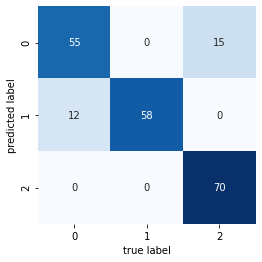

In [81]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix = confusion_matrix(target, labels)
sns.heatmap(matrix, square=True, annot=True, fmt='d', cbar=False, cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label');